In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lr_utils import load_dataset
import h5py
import time

In [2]:
def shuffle_data(X, Y):
    m = X.shape[1]
    permutation = np.random.permutation(m)
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]
    return X_shuffled, Y_shuffled

In [104]:
def create_mini_batches(X, batch_size=64):
    m = X.shape[1]
    mini_batches = []
    num_full_batches = m // batch_size

    for k in range(num_full_batches):
        mini_batch = X[:, k * batch_size : (k + 1) * batch_size]
        mini_batches.append(mini_batch)

    if m % batch_size != 0:
        mini_batch = X[:, num_full_batches * batch_size :]
        mini_batches.append(mini_batch)

    return mini_batches

In [90]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
train_set_x = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
train_set_x = train_set_x/255.
test_set_x = test_set_x/255.
train_set_x_shuffled, train_set_y_shuffeled = shuffle_data(train_set_x, train_set_y)
print(train_set_x_shuffled.shape)
train_x_mini = create_mini_batches(train_set_x_shuffled)
train_y_mini = create_mini_batches(train_set_y_shuffeled)
print(train_x_mini[0].shape)
#print(train_x_mini[0][0])

(12288, 209)
(12288, 128)


In [4]:
def sigmoid(z):
    a = 1/ (1+ np.exp(-z))
    return a

In [5]:
def RELU(z):
    a = np.maximum(0, z)
    return a

In [6]:
def tanh(z):
    a = np.tanh(z)
    return a

In [7]:
def initialize_zero(dimensions):
    layers = dimensions.shape[0]
    B = np.empty((layers, 1), dtype=object)

    for l in range(layers):
        b = np.zeros((dimensions[l][0], 1))
        B[l, 0] = b
    return B

In [8]:
def initialize_random(dimensions):
    layers = dimensions.shape[0]
    W = np.empty((layers, 1), dtype=object)
    for l in range(layers):
        w = np.random.rand(dimensions[l][1], dimensions[l][0])
        W[l,0] = w
    return W

In [9]:
def HE_initialize(dimensions):
    layers = dimensions.shape[0]
    W = np.empty((layers, 1), dtype=object)
    for l in range(layers):
        #print(dimensions[l][1])
        w = np.random.rand(dimensions[l][1], dimensions[l][0])* np.sqrt(2 /dimensions[l][1])
        W[l,0] = w
    return W

In [10]:
def forward_propagation(W, X, B):
    layers = W.shape[0]
    A = np.empty((layers+ 1, 1), dtype=object)
    A[0][0] = X
    for l in range(layers):
        z = np.dot(W[l][0].T, A[l][0]) + B[l][0]
        if l != layers-1:
            a = RELU(z)
        else:
            a = sigmoid(z)
        A[l+1,0] = a
    return A

In [53]:
def backward_propagation(W, B, A, Y, use_L2 = False, lambd = 0.1):
    m = Y.shape[1]
    L = W.shape[0] 
    dW = np.empty_like(W)
    dB = np.empty_like(B)
    dZ = None

    A_final = A[L, 0]  # A[4]
    dZ = A_final - Y  # sigmoid derivative for BCE
    if use_L2 == True:
        dW[L-1, 0] = np.dot(A[L-1, 0], dZ.T) / m + (lambd / m) * W[L-1, 0]
    else:
        dW[L-1, 0] = np.dot(A[L-1, 0], dZ.T) / m  # A3 * dZ4.T
    dB[L-1, 0] = np.sum(dZ, axis=1, keepdims=True) / m

    for l in reversed(range(L - 1)):
        Z = np.dot(W[l, 0].T, A[l, 0]) + B[l, 0]  # recompute Z[l+1]
        dA = np.dot(W[l + 1, 0], dZ)  # backprop through W
        dZ = dA * (Z > 0)  # ReLU derivative
        if use_L2 == True:
            dW[l, 0] = np.dot(A[l, 0], dZ.T) / m + (lambd / m) * W[l, 0]
        else:
            dW[l, 0] = np.dot(A[l, 0], dZ.T) / m
        dB[l, 0] = np.sum(dZ, axis=1, keepdims=True) / m

    return dW, dB

In [52]:
def calculate_cost(Y, A, use_L2 = False, lambd = 0.1):
    m = Y.shape[1]
    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    if use_L2 == True:
        L2_cost = 0
        for l in range(W.shape[0]):
            L2_cost += np.sum(np.square(W[l, 0]))
        L2_cost *= lambd / (2 * m)
        return cost + L2_cost
    return cost

In [13]:
def perdiction(Z):
    for i in range(Z.shape[1]):
        if Z[0][i] > 0.5:
            Z[0][i] = 1
        else:
            Z[0][i] = 0
    return Z
        

In [14]:
def get_layer():
    Layers = int(input("input number of layers: "))
    neurons = []
    for i in range(Layers):
        neurons.append(int(input("input nerouns for " + str(i+1) + "th layer: ")))
    dim = []
    for i in range(Layers):
        if i == 0:
            dim.append([neurons[0], 12288])
        else:
            dim.append([neurons[i], neurons[i-1]])
        if i == (Layers - 1):
            dim.append([1, neurons[i]])
    dim = np.array(dim)
    use_L2 = int(input("do you want to use L2 initialization: "))
    return Layers, dim, use_L2

In [150]:
def model(X_mini, Y_mini, X, Y, learning_rate = 0.005, num_itiration = 501):
    Layers, dim, use_L2 = get_layer()
    cost = []
    W = HE_initialize(dim)
    B = initialize_zero(dim)
    for i in range(num_itiration):
        for j in range(len(X_mini)):
            A = forward_propagation(W, X_mini[j], B)
            dW, dB = backward_propagation(W, B, A, Y_mini[j], use_L2)
            W -= dW * learning_rate
            B -= dB * learning_rate
        if i >= 50:
            A = forward_propagation(W, X, B)
            cost.append(calculate_cost(Y, A[-1][0], use_L2))
            if i%1000 ==0 or i == num_itiration - 1:
                print(cost[i -50])
    plt.plot(range(num_itiration- 50), cost) 
    plt.show()
    return W, B

In [151]:
def test_deep(X, Y, W, B):
    count = 0
    A = forward_propagation(W, X, B)
    Z = perdiction(A[-1][0])
    for i in range(Y.shape[1]):
        if Z[0][i] == Y[0][i]:
            count += 1
    accuricy = count/Y.shape[1] * 100
    return accuricy

input number of layers:  1
input nerouns for 1th layer:  5
do you want to use L2 initialization:  0


0.3054346034670254


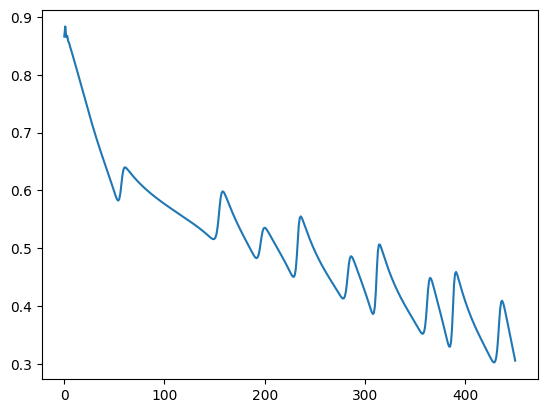

89.47368421052632 
 68.0


In [154]:
W, B = model(train_x_mini, train_y_mini, train_set_x_shuffled, train_set_y_shuffeled)
acc_test = test_deep(test_set_x, test_set_y, W, B)
acc_train = test_deep(train_set_x, train_set_y, W, B)
print(acc_train, "\n", acc_test)